# Predicting Time Series Forecast - Fast Food Sales

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib inline

### Importing data from Excel file. The data contains the monthly sale from 2014 to October 2017

In [2]:
df = pd.read_excel('Faturamento.xlsx')
df.head()

,Data,Vendas
0,2017-10-01,132573
1,2017-09-01,140939
2,2017-08-01,124636
3,2017-07-01,141766
4,2017-06-01,137397


### Transforming the "Data" column to Index

In [3]:
df.index = df['Data']
df.drop('Data', axis=1 , inplace=True)


<function matplotlib.pyplot.show>

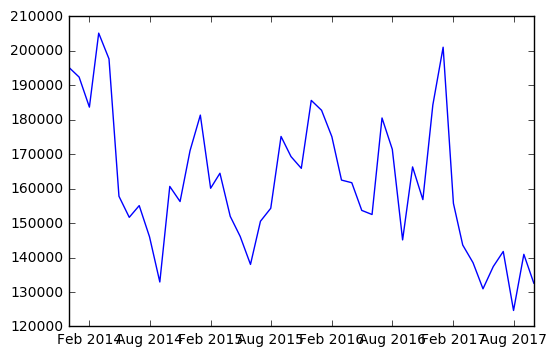

In [4]:
t = df.index.values
x = df.iloc[:,0]
pl.plot(x)
pl.show

In [5]:
df.head()

,Vendas
Data,
2017-10-01,132573
2017-09-01,140939
2017-08-01,124636
2017-07-01,141766
2017-06-01,137397


### Creating the Output column (dependent column) for tranning data set, wich will be the "Vendas" shiftted by 1. It means the predicted sales to a month will be the sales of next month.

In [6]:
df['out'] = df['Vendas'].shift(1)
df.head()

,Vendas,out
Data,,
2017-10-01,132573,NaN
2017-09-01,140939,132573.0
2017-08-01,124636,140939.0
2017-07-01,141766,124636.0
2017-06-01,137397,141766.0


In [7]:
df1=df.copy()
df1.dropna(axis=0 , inplace=True)
df1.head()

,Vendas,out
Data,,
2017-09-01,140939,132573.0
2017-08-01,124636,140939.0
2017-07-01,141766,124636.0
2017-06-01,137397,141766.0
2017-05-01,130927,137397.0


### Normalizing the Data

In [8]:
df2 = (df1-df1.mean())/(df1.max() - df1.min())
df2.head()


,Vendas,out
Data,,
2017-09-01,-0.262614,-0.349597
2017-08-01,-0.465090,-0.245694
2017-07-01,-0.252343,-0.448171
2017-06-01,-0.306604,-0.235423
2017-05-01,-0.386959,-0.289685


In [9]:
t = df2.index.values
x = df2.iloc[:,0]
y = df2.iloc[:,1]

## Linear Regression 

### One Variable (sales shiftted by 1)
### Spliting the data into train and test
### Using seed to reproduce the variable selection
### MSE as a metric

In [10]:
seed=7
from sklearn import model_selection
x_train , x_test , y_train , y_test = model_selection.train_test_split(x,y,test_size=0.2, random_state=seed)


In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

In [12]:
regr = LinearRegression()
x_train=x_train.reshape(-1,1)
y_train=y_train.reshape(-1,1)
regr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
def rmse(y_real,y_pred):
    return np.sqrt(sum([ (m - n)**2 for m, n in zip(y_real,y_pred[:-1])]))/len(y_real)

In [14]:
x_test = x_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)
mean_squared_error_train = rmse(y_train, regr.predict(x_train))
mean_squared_error_test = rmse(y_test, regr.predict(x_test))
print('Mean train squared error: %.5f' %  mean_squared_error_train)
print('Mean test squared error: %.5f' %  mean_squared_error_test)

Mean train squared error: 0.02796
Mean test squared error: 0.06921


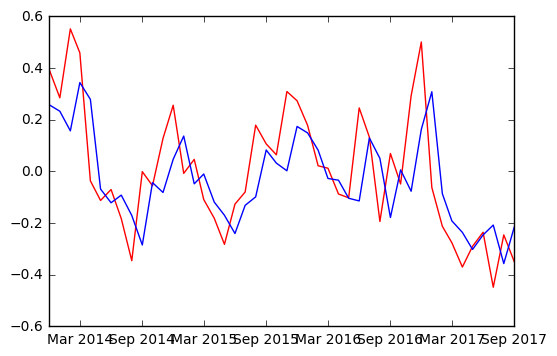

In [15]:
x=x.reshape(-1,1)
y_pred = regr.predict(x)
pl.plot(t,y,'r-')
pl.plot(t,y_pred)
pl.show()

### Creating the new input data to predict

In [16]:
p= (132573-df1['Vendas'].mean())/(df1['Vendas'].max() - df1['Vendas'].min())
p

-0.36651593972506302

In [17]:
#p2= np.array(p)
#p2=p.reshape(1,-1)
prev = regr.predict(p)
prev

array([[-0.28758359]])

### Result (prediction for next month)

In [18]:
prev = (prev*(df1['out'].max() - df1['out'].min()))+df1['out'].mean()
prev

array([[ 137566.1704279]])

### Multi Variable (sales shiftted by "Window")
### Selecting the best "Window" result

In [19]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import ensemble
from sklearn.svm import SVR


import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt

def rmse(y_real,y_pred):
    return np.sqrt(sum([ (m - n)**2 for m, n in zip(y_real,y_pred[:-1])]))/len(y_real)
        
def TestarMetodo(model):
    t = df2.index.values
    train_err_list= []
    test_err_list= []
    janela_list =[]
    seed=7
    for janela in range(1,12):
        df3=df2.copy()
        for i in range(1,janela):
            df3['Vendas' + str(i) ] = df3['Vendas'].shift(-i)

        df3.dropna(axis=0 , inplace=True)
        x = df3.drop('out',axis=1)
        y = df3['out']

        x_train , x_test , y_train , y_test = model_selection.train_test_split(x,y,test_size=0.2, random_state=seed)

        model.fit(x_train,y_train)
        
        mean_squared_error_train = rmse(y_train, model.predict(x_train))
        mean_squared_error_test = rmse(y_test, model.predict(x_test))

        train_err_list.append(mean_squared_error_train)
        test_err_list.append(mean_squared_error_test)
        janela_list.append(janela)


    plt.plot(janela_list,train_err_list,'b',janela_list,test_err_list,'r')
    plt.title('RMSE vs. #Janelas')
    plt.xlabel('#Janelas')
    plt.ylabel('RMSE')
    plt.show()
    return train_err_list , test_err_list , janela_list

In [20]:
def bestResult(erro1,erro2,janela_list):
    min_err = np.array(erro2).min()
    id = np.array(erro2).argmin()

    result = (erro1[id],min_err)
    janela = janela_list[id]
    print('( %f , %f )' % result)
    print('janela: %f' % janela)
    return result , janela

In [21]:
#def bestResult(erro1,err2,janela_list):
    #min_err = np.array(erro1).min()
    #id = np.array(erro1).argmin()

    #result = (min_err , err2[id])
    #janela = janela_list[id]
    #print('( %f , %f )' % result)
    #print('janela: %f' % janela)
    #return result , janela

# Linear Regression

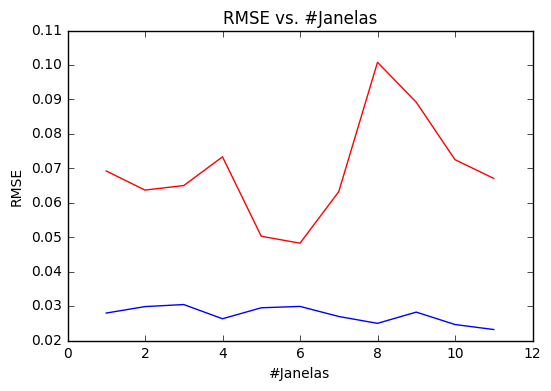

Erro:
( 0.029900 , 0.048254 )
janela: 6.000000


In [22]:
linear_reg = LinearRegression()
linear_train_err_list , linear_test_err_list , linear_janela_list = \
                            TestarMetodo(linear_reg)
print('Erro:')
linear_result , linear_janela = bestResult(linear_train_err_list,linear_test_err_list,linear_janela_list)

In [23]:
for janela in range(1,7):
        df3=df2.copy()
        for i in range(1,janela):
            df3['Vendas' + str(i) ] = df3['Vendas'].shift(-i)

In [24]:
df3.head()

,Vendas,out,Vendas1,Vendas2,Vendas3,Vendas4,Vendas5
Data,,,,,,,
2017-09-01,-0.262614,-0.349597,-0.465090,-0.252343,-0.306604,-0.386959,-0.292744
2017-08-01,-0.465090,-0.245694,-0.252343,-0.306604,-0.386959,-0.292744,-0.229155
2017-07-01,-0.252343,-0.448171,-0.306604,-0.386959,-0.292744,-0.229155,-0.078891
2017-06-01,-0.306604,-0.235423,-0.386959,-0.292744,-0.229155,-0.078891,0.484151
2017-05-01,-0.386959,-0.289685,-0.292744,-0.229155,-0.078891,0.484151,0.275825


In [25]:
df3.dropna(axis=0 , inplace=True)
t = df3.index.values
x = df3.drop('out',axis=1)
y = df3['out']

In [26]:
seed=7
x_train , x_test , y_train , y_test = model_selection.train_test_split(x,y,test_size=0.2,random_state = seed)

In [27]:
regr = LinearRegression()
regr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [28]:
mean_squared_error_train = rmse(y_train, regr.predict(x_train))
mean_squared_error_test = rmse(y_test, regr.predict(x_test))
print('Mean train squared error: %.5f' %  mean_squared_error_train)
print('Mean test squared error: %.5f' %  mean_squared_error_test)

Mean train squared error: 0.02990
Mean test squared error: 0.04825


### Creating the new input data to predict

In [29]:
p= df.iloc[:6,0]
p= (p-df1['Vendas'].mean())/(df1['Vendas'].max() - df1['Vendas'].min())
p= p.reshape(1,-1)
p

array([[-0.36651594, -0.26261371, -0.46509017, -0.25234271, -0.30660387,
        -0.38695857]])

In [30]:
prev = regr.predict(p)

### Result (prediction for next month)

In [31]:
prev = (prev*(df1['out'].max() - df1['out'].min()))+df1['out'].mean()
prev

array([ 145382.84289661])